In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [11]:
import numpy as np
import matplotlib
#matplotlib.use("Agg")

# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense
#from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
#from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pickle
import cv2
import os
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import tensorflow as tf
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.preprocessing import LabelBinarizer
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
import os

In [12]:
x=np.load("data.csv.npy")
y=np.load("labels.npy")

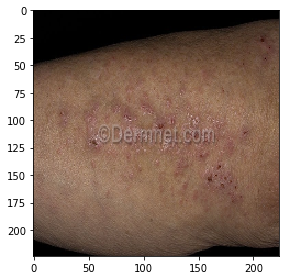

In [13]:
imshow(x[2005])

In [14]:
(trainX, testX, trainY, testY) = train_test_split(x, y,
test_size=0.20, stratify=y, random_state=42)

In [15]:
trainAug = ImageDataGenerator(
	rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")
valAug = ImageDataGenerator()
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean

In [16]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

for layer in baseModel.layers:
	layer.trainable = False


headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(23, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

In [17]:
print("[INFO] compiling model...")
opt = SGD(learning_rate=1e-2, momentum=0.9, decay=1e-4 / 25)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])
print("[INFO] training head...")
H = model.fit_generator(
	trainAug.flow(trainX, trainY, batch_size=32),
	steps_per_epoch=len(trainX) // 32,
	validation_data=valAug.flow(testX, testY),
	validation_steps=len(testX) // 32,
	epochs=25)

[INFO] compiling model...
[INFO] training head...


MemoryError: Unable to allocate 6.98 GiB for an array with shape (12445, 224, 224, 3) and data type float32